## linear operator speed profiling

In [1]:
import numpy as np
from scipy.sparse.linalg import LinearOperator, eigsh
from scipy.stats import beta
import pandas as pd
import seaborn as sns
from graspologic.simulations import sbm
from graspologic.utils import to_laplacian
from time import time
np.set_printoptions(suppress=True)

def make_community(a, b, n=500):
    return beta.rvs(a, b, size=(n, 5))

def gen_covariates(n):
    c1 = make_community(2, 5, n=n)
    c2 = make_community(2, 2, n=n)

    covariates = np.vstack((c1, c2))
    return covariates

def gen_network(n):
    P = np.array([[.08, .02], [.02, .08]])
    A = sbm([n//2, n//2], P)
    Y = gen_covariates(n=n//2)
    return A, Y

nodes = np.geomspace(100, 10000, 20).astype(int)
nodes[nodes % 2 == 1] += 1

true eigenvalues

# Test speed increase in calculating leading eigenvalues

Here is the true speed increase gained from using the Lanczos method, since we do not convert to Laplacian in this code.  
This compares the time it takes to calculate the leading eigenvalue of $YY^\top$ with and without the Lanczos method from the paper.

In [2]:
def _matvec(v):
    return Y@(Y.T@v)

slows = {}
fasts = {}
for n in nodes:
    A, Y = gen_network(n)
    
    # calculating Y@Y.T
    start = time()
    YYt = Y@Y.T
    Le_calc = eigsh(YYt, k=1, return_eigenvectors=False)
    slows[n] = time() - start
    
    # as LinearOperator
    start = time()
    YYt_O = LinearOperator((n, n), matvec=_matvec)
    Le_LO = eigsh(YYt_O, k=1, return_eigenvectors=False)
    fasts[n] = time() - start

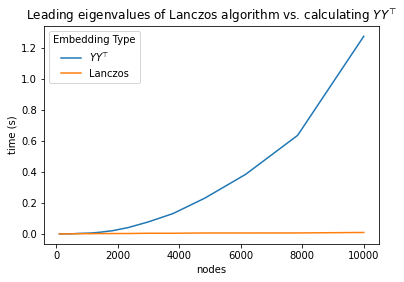

In [3]:
import matplotlib.pyplot as plt

times = slows.copy()
df = pd.DataFrame(times.values(), index=times.keys(), columns=["Slow"])
df.reset_index(inplace=True)

df["Fast"] = fasts.values()
melted = pd.melt(df, id_vars="index")
melted.rename(columns={"index": "nodes", "variable": "Embedding Type", "value": "time (s)"},
              inplace=True)
melted["Embedding Type"].replace({"Slow": r"$YY^\top$", "Fast": "Lanczos"}, inplace=True)
ax_leading = sns.lineplot(data=melted, x="nodes", y="time (s)", hue="Embedding Type")
ax_leading.set(title=r"Leading eigenvalues of Lanczos algorithm vs. calculating $YY^\top$")
plt.savefig("../figs/leading_eigvals_speed.png", bbox_inches="tight")

#### Eigenvalues are the same

In [4]:
print(Le_calc)
print(Le_LO)

[8631.13673136]
[8631.13673136]


## Test speed increase in embedding matrix

the source of the exponential growth in the Lanczos version is because converting the adjacency matrix to a Laplacian is not linear, I think

In [5]:
def _matvec(v):
    return L@(L@v) + Y@(Y.T@v)

slows = {}
fasts = {}
for n in nodes:
    A, Y = gen_network(n)
    
    # calculating Y@Y.T
    start = time()
    L = to_laplacian(A, form="R-DAD")
    L_ = L@L + Y@Y.T
    D, U = eigsh(L_, k=2)
    slows[n] = time() - start
    
    # as LinearOperator
    start = time()
    L = to_laplacian(A, form="R-DAD")
    L_ = LinearOperator((n, n), matvec=_matvec)
    D_, U_ = eigsh(L_, k=2)
    fasts[n] = time() - start

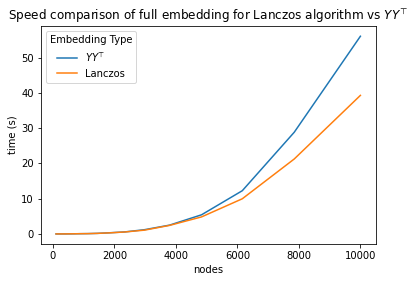

In [6]:
times = slows.copy()
df = pd.DataFrame(times.values(), index=times.keys(), columns=["Slow"])
df.reset_index(inplace=True)

df["Fast"] = fasts.values()
melted = pd.melt(df, id_vars="index")
melted.rename(columns={"index": "nodes", "variable": "Embedding Type", "value": "time (s)"},
              inplace=True)
melted.head()
melted["Embedding Type"].replace({"Slow": r"$YY^\top$", "Fast": "Lanczos"}, inplace=True)
ax = sns.lineplot(data=melted, x="nodes", y="time (s)", hue="Embedding Type")
ax.set(title=r"Speed comparison of full embedding for Lanczos algorithm vs $YY^\top$")

plt.savefig("../figs/full_embedding_speed.png", bbox_inches="tight")

#### Eigenvalues are the same

In [7]:
print(D)
print(D_)

[ 387.49767214 8628.25231903]
[ 387.49767214 8628.25231903]


## Assortative Case

In [25]:
def _matvec(L, Y):
    mv = lambda v: L@v + Y@(Y.T@v)
    return mv

slows = {}
fasts = {}
for n in nodes:
    A, Y = gen_network(n)
    
    # calculating Y@Y.T
    start = time()
    L = to_laplacian(A, form="R-DAD")
    L_ = L + Y@Y.T
    D, U = eigsh(L_, k=2)
    slows[n] = time() - start
    
    # as LinearOperator
    start = time()
    L = to_laplacian(A, form="R-DAD")
    L_ = LinearOperator((n, n), matvec=_matvec(L, Y))
    D_, U_ = eigsh(L_, k=2)
    fasts[n] = time() - start

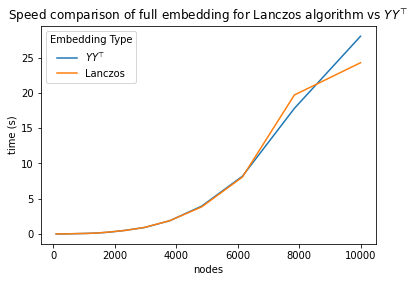

In [26]:
times = slows.copy()
df = pd.DataFrame(times.values(), index=times.keys(), columns=["Slow"])
df.reset_index(inplace=True)

df["Fast"] = fasts.values()
melted = pd.melt(df, id_vars="index")
melted.rename(columns={"index": "nodes", "variable": "Embedding Type", "value": "time (s)"},
              inplace=True)
melted.head()
melted["Embedding Type"].replace({"Slow": r"$YY^\top$", "Fast": "Lanczos"}, inplace=True)
ax = sns.lineplot(data=melted, x="nodes", y="time (s)", hue="Embedding Type")
ax.set(title=r"Speed comparison of full embedding for Lanczos algorithm vs $YY^\top$")

plt.savefig("../figs/full_embedding_speed_assortative.png", bbox_inches="tight")

## graspologic

I went through the CASE code in the debugger to make sure YY^T was never calculated. The source of the exponential growth is converting to Laplacian. Checking symmetry is also an O(n^2) operation, and the graspologic code checks symmetry in both cases.

In [8]:
%load_ext autoreload
%autoreload

from graspologic.embed import CovariateAssistedEmbed as CASE
from graspologic.embed.case import CovariateAssistedEmbedOld as CASEOLD

slows = {}
fasts = {}
for n in nodes:
    A, Y = gen_network(n)
    
    # calculating Y@Y.T
    case_old = CASEOLD(n_components=2, embedding_alg="non-assortative")
    start = time()
    case_old.fit_transform((A, Y))
    slows[n] = time() - start
    
    # as LinearOperator
    case = CASE(n_components=2, assortative=False)
    start = time()
    case.fit_transform((A, Y))
    fasts[n] = time() - start
    

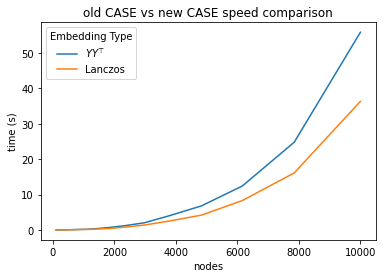

In [11]:
times = slows.copy()
df = pd.DataFrame(times.values(), index=times.keys(), columns=["Slow"])
df.reset_index(inplace=True)

df["Fast"] = fasts.values()
melted = pd.melt(df, id_vars="index")
melted.rename(columns={"index": "nodes", "variable": "Embedding Type", "value": "time (s)"},
              inplace=True)
melted["Embedding Type"].replace({"Slow": r"$YY^\top$", "Fast": "Lanczos"}, inplace=True)
ax = sns.lineplot(data=melted, x="nodes", y="time (s)", hue="Embedding Type")
ax.set(title=r"old CASE vs new CASE speed comparison")

plt.savefig("../figs/case_lanczos_speedup.png", bbox_inches="tight")

In [23]:
%%timeit

def _matvec(v):
    return A@(A@v)


A_ = LinearOperator((n, n), matvec=_matvec)
eigfast, _ = eigsh(A_, k=2)

1.19 s ± 8.65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
def _matvec(v):
    return A@(A@v)


A_ = LinearOperator((n, n), matvec=_matvec)
eigfast, _ = eigsh(A_, k=2)

In [17]:
%%timeit
A_ = A@A
eigslow, _ = eigsh(A_, k=2)

15 s ± 1.26 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


### SVD comparison tests

In [38]:
from graspologic.embed.svd import selectSVD

_, D_trunc, _ = selectSVD(L, n_components=2, algorithm="truncated")
_, D_square, _ = selectSVD(L, n_components=2, algorithm="square")

In [39]:
D_trunc

array([0.50023719, 0.30125304])

In [40]:
D_square

array([0.50023719, 0.30125304])

## Make sure implementation produces the same outcomes